# BiLSTM CRF Tagger

## Download Data/Eval Script

In [4]:
!wget https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py
!wget https://raw.githubusercontent.com/tberg12/cse291spr21/main/assignment2/train.data.quad
!wget https://raw.githubusercontent.com/tberg12/cse291spr21/main/assignment2/dev.data.quad

--2022-05-29 03:14:09--  https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7502 (7.3K) [text/plain]
Saving to: ‘conlleval.py’

conlleval.py        100%[===================>]   7.33K  --.-KB/s    in 0s      

2022-05-29 03:14:09 (69.1 MB/s) - ‘conlleval.py’ saved [7502/7502]

--2022-05-29 03:14:10--  https://raw.githubusercontent.com/tberg12/cse291spr21/main/assignment2/train.data.quad
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 745734 (728K) [text/plain]
S

In [5]:
import random

import conlleval
from tqdm import tqdm
import numpy as np
from collections import defaultdict, Counter
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import vocab
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

torch.manual_seed(291)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

## Data Preparation

In [7]:
TRAIN_DATA = 'train.data.quad'
VALID_DATA = 'dev.data.quad'
UNK = '<unk>'
PAD = '<pad>'
START_TAG = "O-<start>"  # you can add this explicitly or use it implicitly in your CRF layer
STOP_TAG = "O-<stop>"    # you can add this explicitly or use it implicitly in your CRF layer


def read_conll_sentence(path):
    """ Read a CONLL-format sentence into vocab objects
    Args:
        :param path: path to CONLL-format data file
        :param word_vocab: Vocabulary object for source
        :param label_vocab: Vocabulary object for target
    """
    sent = [[], []]
    with open(path) as f:
        for line in f:
            line = line.strip().split()
            if line:
                # replace numbers with 0000
                word = line[0]
                word = '0000' if word.isnumeric() else word
                sent[0].append(word)
                sent[1].append(line[3])
            else:
                yield sent[0], sent[1]
                sent = [[], []]


def prepare_dataset(dataset, word_vocab, label_vocab):
    word_vocab_stoi = word_vocab.get_stoi()
    label_vocab_stoi = label_vocab.get_stoi()
    dataset = [
      [
        torch.tensor([word_vocab_stoi.get(word,0) for word in sent[0]], dtype=torch.long),
        torch.tensor([label_vocab_stoi[label] for label in sent[1]], dtype=torch.long),
      ]
      for sent in dataset
    ]
    random.shuffle(dataset)
    return dataset

In [8]:
# load a list of sentences, where each word in the list is a tuple containing the word and the label
train_data = list(read_conll_sentence(TRAIN_DATA))
train_word_counter = Counter([word for sent in train_data for word in sent[0]])
train_label_counter = Counter([label for sent in train_data for label in sent[1]])
word_vocab = vocab(train_word_counter, specials=[UNK, PAD], min_freq=2)
# print(word_vocab.get_stoi())
# word_vocab.set_default_index(UNK)

In [9]:
label_vocab = vocab(train_label_counter, specials=[START_TAG, STOP_TAG], min_freq=1)
train_data = prepare_dataset(train_data, word_vocab, label_vocab)
print('Train word vocab:', len(word_vocab), 'symbols.')
print('Train label vocab:', len(label_vocab), f'symbols: {list(label_vocab.get_stoi().keys())}')

Train word vocab: 3947 symbols.
Train label vocab: 10 symbols: ['B-LOC', 'B-ORG', 'B-MISC', 'O-<stop>', 'I-ORG', 'I-MISC', 'O-<start>', 'I-PER', 'O', 'I-LOC']


In [10]:
print(' '.join([word_vocab.get_itos()[i.item()] for i in train_data[0][0]]))
print(' '.join([label_vocab.get_itos()[i.item()] for i in train_data[0][1]]))

BEIJING 1996-08-27
I-LOC O


In [11]:
valid_data = list(read_conll_sentence(VALID_DATA))
valid_data = prepare_dataset(valid_data, word_vocab, label_vocab)
print('Train data:', len(train_data), 'sentences.')
print('Valid data:', len(valid_data))

Train data: 3420 sentences.
Valid data: 800


In [12]:
print(' '.join([word_vocab.get_itos()[i.item()] for i in valid_data[0][0]]))
print(' '.join([label_vocab.get_itos()[i.item()] for i in valid_data[0][1]]))

-DOCSTART-
O


In [13]:
# Utils from https://pytorch.org/tutorials/beginner/nlp/advanced_tutorial.html

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()

def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

## BiLSTMTaggerCRF

In [72]:
class BiLSTMCRFTagger(nn.Module):
    def __init__(self, vocab_size, tag_vocab, embedding_dim, hidden_dim, dropout=0.3):
        super(BiLSTMCRFTagger, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tagset_size = len(tag_vocab)   # includes start and stop
        self.tag_index = tag_vocab.get_stoi()
        print("self.tag_index", self.tag_index)
        self.start_tag_index =  self.tag_index[START_TAG]
        self.stop_tag_index =  self.tag_index[STOP_TAG]

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True, batch_first=True)
        self.tag_projection_layer = nn.Linear(hidden_dim, self.tagset_size)  # See baseline for comments on linear layer
        self.dropout = nn.Dropout(p=dropout)

        # log_transition_potential matrix U, for transition from tag i to tag j
        self.U = nn.Parameter(torch.randn(self.tagset_size, self.tagset_size)).to(device) # tagset includes start and stop token

        # transition probabilities (in log) for to-start-tag and from-stop-tag -> 0
        self.U.data[:, self.start_tag_index] = -1e5
        self.U.data[self.stop_tag_index, :] = -1e5

        # print("self.U", self.U, self.U.shape)
        # print("=====")

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2).to(device),
                torch.randn(2, 1, self.hidden_dim // 2).to(device))

    def compute_lstm_emission_features(self, sentence):
        hidden = self.init_hidden()
        embeds = self.dropout(self.word_embeds(sentence))
        # embeds = self.word_embeds(sentence)
        bilstm_out, hidden = self.bilstm(embeds, hidden)
        bilstm_out = self.dropout(bilstm_out)
        bilstm_f_logits = self.tag_projection_layer(bilstm_out)
        return bilstm_f_logits

    def decode(self, bilstm_f_logits):
        # Decode the most likely sequence exactly, using Viterbi algorithm
        # print("decoding")
        len_sentence = len(bilstm_f_logits[0])

        L = torch.full((self.tagset_size, len_sentence+1), fill_value=-1e5).to(device) # store score for all paths up till a point ending with each tag
        states = torch.full((self.tagset_size, len_sentence+1), fill_value=0).to(device) # we won't be using its 0th column
        # print(L)
        # print(states)

        L[self.start_tag_index, 0] = 0
        for t in range(1, len_sentence+1):
            for tag in range(self.tagset_size):
                prev = L[:, t-1].view(1, -1)
                transition = self.U[:, tag].view(1, -1)
                emission_score = bilstm_f_logits[0][t-1][tag].view(1)
                # print(prev, transition, emission_score)
                states[tag, t] = argmax(prev + transition) # stores best tag for previous location if t-th tag is tag
                # print(states[tag, t], prev[0][states[tag, t]], transition[0][states[tag, t]], emission_score)
                L[tag, t] = prev[0, states[tag, t]] + transition[0, states[tag, t]] + emission_score # stores max NLL for current location if current tag is j
                # print(f"L[{tag}, {t}]", L[tag, t])
            # print()

        path = []
        best_last_tag = argmax(L[:, -1].view(1, -1))
        score = L[best_last_tag, -1]

        c = best_last_tag
        path.append(c)
        t = len_sentence-1
        while t >= 0:
            c = states[c, t+1].item()
            t -= 1
            path.append(c)

        path = path[::-1]
        final_path = torch.tensor(path[1:], dtype=torch.long).view(1, -1)
        # print(path, final_path)
        # print("len(path)", len(path), "len(final_path[0])", len(final_path[0]), "len_sentence", len_sentence)

        assert path[0] == self.start_tag_index
        assert len(final_path[0]) == len_sentence
        assert final_path[0][0] != self.start_tag_index
        return score, final_path

    def forward(self, sentence):
        # Only used during inference i.e. in evaluate function, not loss calculation.
        bilstm_f_logits = self.compute_lstm_emission_features(sentence).to(device)
        score, tagseq = self.decode(bilstm_f_logits)
        return score, tagseq

    def Z(self, sentence, bilstm_f_logits):
        # Calculate partition function Z for the denominator term of the loss using Forward algorithm
        # print("in Z")
        # print("sentence", sentence)
        # print("bilstm_f_logits", bilstm_f_logits[0])

        start_transition_score = self.U[self.start_tag_index, :].view(1, -1)
        start_emit_score = bilstm_f_logits[0][0].view(1, -1)

        # print("start_transition_score", start_transition_score)
        # print("start_emit_score", start_emit_score)
        #
        # init_alphas = torch.full((1, self.tagset_size), -10000.)
        score_till_now = start_transition_score  + start_emit_score # base case
        # print("score_till_now base", score_till_now)

        for t in range(1, len(sentence)):
            # print("moving to next word", i)
            # for each possible tag, score till now
            scores = []
            for tag in range(self.tagset_size):
                transition_score = self.U[:, tag].view(1, -1)
                # print("> transition_score", transition_score)
                emit_score = bilstm_f_logits[0][t][tag].view(1, -1)
                # print("> emit_score", emit_score)
                emission_score = emit_score.expand(1, self.tagset_size) # same score to be added corresponding to any prev tag, hence making copies
                # print("> emission_score", emission_score)
                # print("> sum", score_till_now + transition_score + emission_score)
                score = log_sum_exp(score_till_now + transition_score + emission_score)
                # print("> t score", score)
                scores.append(score.view(1))
            assert len(scores) == self.tagset_size
            score_till_now = torch.cat(scores).view(1, -1).to(device)
            # print(">>> score_till_now", score_till_now, "\n")

        # print("done, add stop")
        z = log_sum_exp(score_till_now + self.U[:, self.stop_tag_index].view(1, -1))

        # print("score_till_now last", z)
        return z

    def loss(self, sentence, tags):
        # Loss function for training
        # print("in loss")

        # get logits
        bilstm_f_logits = self.compute_lstm_emission_features(sentence).to(device)

        # GET numerator: score for current tag sequence
        score = torch.zeros(1).to(device)
        # print("got tags", tags)
        # print("len(sentence)", len(sentence[0]))
        score += self.U[self.start_tag_index, tags[0]] + bilstm_f_logits[0][0][tags[0]]
        for t in range(1, len(sentence[0])):
            score += self.U[tags[t-1], tags[t]] + bilstm_f_logits[0][t][tags[t]]
        score += self.U[tags[-1], self.stop_tag_index]

        # GET denominator: sum of scores for all possible tag sequences
        z = self.Z(sentence[0], bilstm_f_logits)

        final_loss = -score + z
        # print("N D final", score, z, final_loss, "\n")
        return final_loss

## Train / Eval loop

In [73]:
def train(model, train_data, valid_data, word_vocab, label_vocab, epochs, log_interval=25):
    train_losses_per_epoch = []
    mean_train_losses_per_epoch = []
    mean_valid_losses_per_epoch = []
    valid_eval_results = []
    label_vocab_itos = label_vocab.get_itos()
    word_vocab_itos = word_vocab.get_itos()
    for epoch in range(epochs):
        print(f'\n--- EPOCH {epoch} ---')
        model.train()
        train_losses_per_epoch.append([])
        c = 100
        for i, (sent, tags) in enumerate(train_data):
            # print("sent, tags", sent, tags)
            model.zero_grad() # set prev gradients to 0
            sent, tags = sent.to(device), tags.to(device)
            sent = sent.unsqueeze(0)
            tags = tags.unsqueeze(0)
            # print(sent, [word_vocab_itos[i] for i in sent[0]])
            # print(sent, [label_vocab_itos[i] for i in tags[0]])
            # print("unsq", sent, tags)
            # print("len input", len(sent[0]))
            loss = model.loss(sent, tags[0])
            loss.backward()
            optimizer.step()
            train_losses_per_epoch[-1].append(loss.detach().cpu().item())
            if i > 0 and i % log_interval == 0:
                mean_loss = np.mean(train_losses_per_epoch[-1][-log_interval:])
                print(f'Avg loss over last {log_interval} updates: {mean_loss}')
            if not c: break
            # c -= 1
        mean_train_losses_per_epoch.append(np.mean(train_losses_per_epoch[-1]))

        mean_valid_loss, eval_result = evaluate(model, valid_data, word_vocab, label_vocab, log_interval)
        mean_valid_losses_per_epoch.append(mean_valid_loss)
        valid_eval_results.append(eval_result)
    return mean_train_losses_per_epoch, train_losses_per_epoch, mean_valid_losses_per_epoch, valid_eval_results


def evaluate(model, dataset, word_vocab, label_vocab, log_interval):
    print("evaluating..")
    model.eval()
    losses = []
    scores = []
    true_tags = []
    pred_tags = []
    sents = []
    label_vocab_itos = label_vocab.get_itos()
    word_vocab_itos = word_vocab.get_itos()
    c = 100
    for i, (sent, tags) in enumerate(dataset):
        with torch.no_grad():
            # print("sent, tags", sent, tags)
            sent, tags = sent.to(device), tags.to(device)
            sent = sent.unsqueeze(0)
            tags = tags.unsqueeze(0)
            # print(sent, [word_vocab_itos[i] for i in sent[0]])
            # print(tags, [label_vocab_itos[i] for i in tags[0]])
            this_loss = model.loss(sent, tags[0]).cpu().detach().item()
            # print("this_loss", this_loss)
            losses.append(this_loss)
            score, pred_tag_seq = model(sent)
            scores.append(score.cpu().detach().numpy())
            true_tags.append([label_vocab_itos[i] for i in tags.tolist()[0]])
            pred_tags.append([label_vocab_itos[i] for i in pred_tag_seq[0]])
            sents.append([word_vocab_itos[i] for i in sent[0]])
        if i > 0 and i%log_interval == 0:
            print("Evaluated", i)
        if not c: break
        # c -= 1

    mean_valid_loss = np.mean(losses)
    print('Avg evaluation loss:', )
    eval_result = conlleval.evaluate([tag for tags in true_tags for tag in tags], [tag for tags in pred_tags for tag in tags], verbose=True)
    k=2
    print(f'\n{k} random evaluation samples:')
    for i in np.random.randint(0, len(sents), size=k):
        print('SENT:', ' '.join(sents[i]))
        print('TRUE:', ' '.join(true_tags[i]))
        print('PRED:', ' '.join(pred_tags[i]))
    return mean_valid_loss, eval_result

## Training

In [ ]:
# Train BiLSTM Tagger CRF
model = BiLSTMCRFTagger(vocab_size=len(word_vocab), tag_vocab=label_vocab, embedding_dim=128, hidden_dim=256).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
mean_train_losses_per_epoch, train_losses, valid_losses, valid_evals = train(model, train_data, valid_data, word_vocab, label_vocab, epochs=15, log_interval=500)

In [77]:
torch.save(model, 'model-crf-2.pt')

In [ ]:
valid_losses, mean_train_losses_per_epoch

Text(0, 0.5, 'Validation Loss')

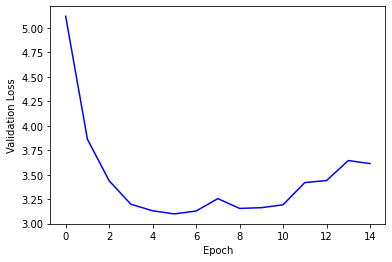

In [88]:
plt.plot(valid_losses, 'b-')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')

Text(0, 0.5, 'Training Loss')

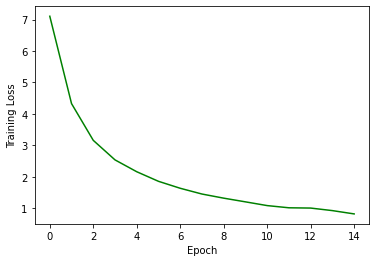

In [89]:
plt.plot(mean_train_losses_per_epoch, 'g-')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

Text(0, 0.5, 'Training and Validation Loss')

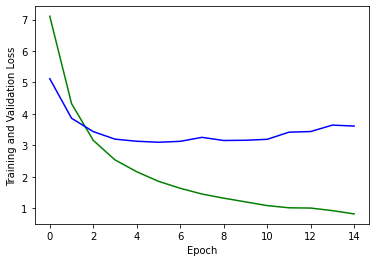

In [90]:
plt.plot(mean_train_losses_per_epoch, 'g-')
plt.plot(valid_losses, 'b-')
plt.xlabel('Epoch')
plt.ylabel('Training and Validation Loss')

In [82]:
precisions, recalls, f1s = [r[0] for r in valid_evals], [r[1] for r in valid_evals], [r[2] for r in valid_evals]

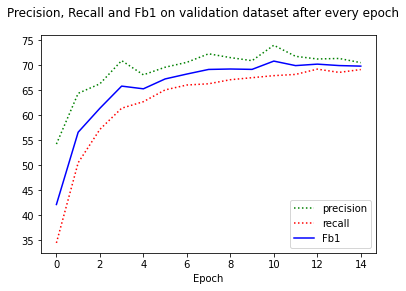

In [85]:
fig, ax1 = plt.subplots()
ax1.plot(precisions, 'g:', label='precision')
ax1.plot(recalls, 'r:', label='recall')
ax1.plot(f1s, 'b', label='Fb1')
ax1.set_xlabel('Epoch')
plt.legend()
plt.suptitle("Precision, Recall and Fb1 on validation dataset after every epoch")
plt.show()

In [94]:
def sampling(model, word_vocab, label_vocab):
    print("example..")
    label_vocab_itos = label_vocab.get_itos()
    word_vocab_itos = word_vocab.get_itos()
    word_vocab_stoi = word_vocab.get_stoi()
    label_vocab_stoi = label_vocab.get_stoi()

    # sent, tags = random.choice(valid_data)
    # sentence = [word_vocab_itos[i] for i in sent]
    # true_tags = [label_vocab_itos[i] for i in tags]
    # print('SENT:', ' '.join(sentence))
    # print('TRUE:', ' '.join(true_tags))

    sentence = "Nigeria is under fire from many Western countries for human rights <unk>".split()
    sent = torch.tensor([word_vocab_stoi.get(word, 0) for word in sentence], dtype=torch.long)
    print('SENT:', ' '.join(sentence))

    sent = sent.to(device)
    sent = sent.unsqueeze(0)
    score, pred_tag_seq = model(sent)
    pred_tags = [label_vocab_itos[i] for i in pred_tag_seq[0]]

    print('PRED:', ' '.join(pred_tags))
    pass

sampling(model, word_vocab, label_vocab)

example..
SENT: Nigeria is under fire from many Western countries for human rights <unk>
PRED: I-LOC O O O O O I-MISC O O O O O
